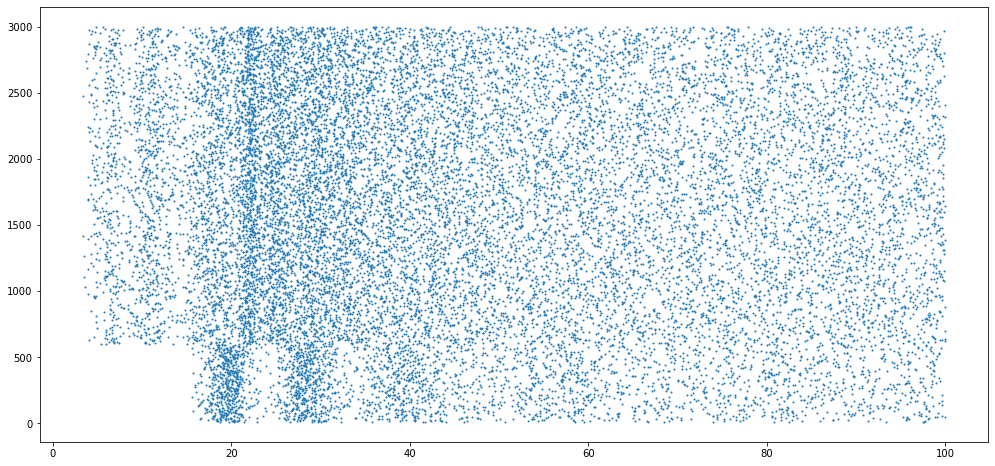

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('spts.txt', header=None)
plt.figure(figsize=(17,8))
plt.plot(df[1], df[0], 'o', ms=1)

58.92 s


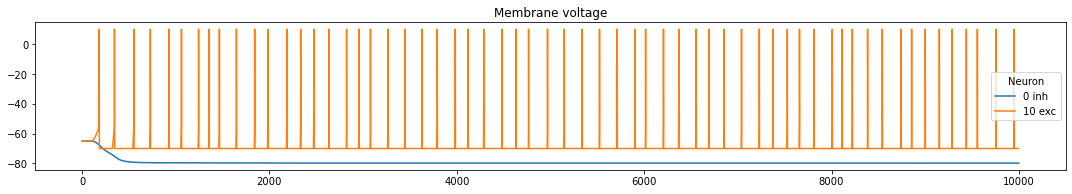

TypeError: 'int' object is not subscriptable

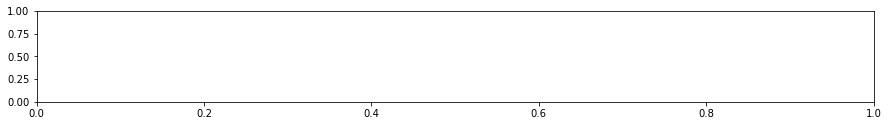

In [15]:
# same as above, but jitted with numba (gives a 2x performance boost)

import time
import numpy as np
from LIFclasses import *
from numba import jit, prange

seed = 20
np.random.seed(seed)

@jit (nopython=True, fastmath=True, nogil=True, parallel=True)
def run_numba():
    N = 3000
    T = 100
    dt = 0.01
    t = np.arange(0, T, dt)
    
    refractory_period = 1
    AP = np.zeros((N, 1))
    
    # equilibrium potentials:
    V_E = 0.0
    V_I = -80.0  # equilibrium potential for the inhibitory synapse
    EL = -65.0  # leakage potential, mV

    # critical voltages:
    Vth = -55.0  # threshold after which an AP is fired,   mV
    Vr = -70.0  # reset voltage (after an AP is fired), mV
    Vspike = 10.0

    # define neuron types in the network:
    neur_type_mask = np.zeros_like(AP)
    neur_type_mask[:10] = 0
    neur_type_mask[10:] = 1  

    # initialize spikes
    exc_id = np.where(neur_type_mask == 1)[0]
    ons = np.random.choice(exc_id, int(0.4*len(exc_id)), replace=False)
    for a in ons:
        AP[a, 0] = 1

    # taus
    tau = np.zeros((1, N))
    idx = np.where(neur_type_mask == 0)[0]
    for j in idx:
        tau[0, j] = 10
    idx = np.where(neur_type_mask == 1)[0]
    for j in idx:
        tau[0, j] = 20
    

    tau_ampa = 8
    tau_nmda = 100
    tau_gaba = 8
    
    V = np.ones((1, N)) * EL


    # define weights:
    w = np.zeros((N, N))
    NE = int(N*0.8)
    NI = N-NE
    # II
    for i in range(NI):
        for j in range(NI):
            if np.random.rand() > 0.8:
                w[i,j] = np.random.rand() + 0.1
    # IE
    for i in range(NI,N):
        for j in range(NI):
            if np.random.rand() > 0.8:
                w[i,j] = np.random.rand() + 1.2
    # EI
    for i in range(NI):
        for j in range(NI,N):
            if np.random.rand() > 0.8:
                w[i,j] = np.random.rand() + 0.7
    # EE
    for i in range(NI,N):
        for j in range(NI,N):
            if np.random.rand() > 0.8:
                w[i,j] = np.abs(np.random.rand() + 0.1)
    # prohibit self-connections
    for i in range(N):
        w[i, i] = 0

    i = 0
    t = np.arange(0, T, dt)
    V = V * 0 + EL
    
    EPSILON = 0.001
    
    ampa = np.zeros((N, N))
    nmda = np.zeros((N, N))
    gaba = np.zeros((N, N))
    in_refractory = - np.ones((1, N)) # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! -----------------------------
    VV = np.zeros((N, len(t)))
    # AMPA = np.zeros((N, N, len(t)))
    # NMDA = np.zeros((N, N, len(t)))
    # GABA = np.zeros((N, N, len(t)))
    dV = np.zeros((1, N))
    I_E = np.zeros((1, N))
    I_I = np.zeros((1, N))
    delayed_spike = np.zeros((N, ))
    
    for i in range(len(t)):
        
        for ii in prange(N):

            if AP[ii] == 1.0:                                   # if a neuron spikes
                in_refractory[0, ii] = refractory_period + np.random.rand()       # we set it's refractory timer
                AP[ii] = 0.0                                    # clear this spike

            if np.abs(in_refractory[0, ii]) < EPSILON:
                delayed_spike[ii] = 1.0
            else:
                delayed_spike[ii] = 0.0

            I_E[0,ii] = 0.0
            I_I[0,ii] = 0.0

            for jj in range(N):
                ampa[ii, jj] += (-ampa[ii, jj] / tau_ampa + neur_type_mask[ii, 0] * delayed_spike[jj] * w[ii, jj]) * dt
                nmda[ii, jj] += (-nmda[ii, jj] / tau_nmda + neur_type_mask[ii, 0] * delayed_spike[jj] * w[ii, jj]) * dt
                gaba[ii, jj] += (-gaba[ii, jj] / tau_gaba + (1.0 - neur_type_mask[ii, 0]) * delayed_spike[jj] * w[ii, jj]) * dt

                I_E[0,ii] += -ampa[ii,jj] * (V[0,ii] - V_E) - 0.1 * nmda[ii,jj] * (V[0,ii] - V_E)
                I_I[0,ii] += -gaba[ii,jj] * (V[0,ii] - V_I)


            dV[0,ii] = (-(V[0,ii] - EL) / tau[0,ii] + I_E[0,ii] + I_I[0,ii] ) * dt

            if V[0, ii] >= Vspike:
                V[0, ii] = Vr
        
            if in_refractory[0, ii] > 0: # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!--------------------
                dV[0, ii] = 0.0
            
            V[0, ii] += dV[0, ii]
        
            if V[0, ii] > Vth:
                V[:, ii] = Vspike
                AP[ii] = 1

            VV[ii, i] = V[0, ii]
            # AMPA[ii, :, i] = ampa[ii, :]
            # NMDA[ii, :, i] = nmda[ii, :]
            # GABA[ii, :, i] = gaba[ii, :]
            
        
        in_refractory -= dt
    AMPA, NMDA, GABA = 0, 0, 0

    return w, neur_type_mask, t, AMPA, NMDA, GABA, VV

tt = time.time()
w, neur_type_mask, t, AMPA, NMDA, GABA, VV = run_numba()
print(f'{(time.time() - tt):.2f} s')

plot_sim_res('V', neur_type_mask, t, AMPA, NMDA, GABA, VV, neur=[0,10])
plt.show()
# plot_sim_res('V', net, neur=[2,3])
# plot_sim_res('V', net, neur=[4,5])
plot_sim_res('G', neur_type_mask, t, AMPA, NMDA, GABA, VV, neur=[3], syn=[10])
plt.show()
# plot_sim_res('E', net, neur=[4,5])

plt.figure(figsize=(15,5))

x, y = np.where(VV > 0)
plt.plot(y, x, 'bo', ms=0.5)
plt.show()

In [16]:
tt = time.time()
w, neur_type_mask, t, AMPA, NMDA, GABA, VV = run_numba()
print(f'{(time.time() - tt):.2f} s')

56.41 s
